In [1]:
from glob import glob
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sns.set_style('white', {'axes.grid' : False})

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

In [2]:
sample = 'dcis1'

In [3]:
adata = sc.read_h5ad('dcis1.cluster.h5ad')

In [4]:
adata.uns['log1p']['base'] = None

In [5]:
sc.tl.rank_genes_groups(adata, "RNA_cluster", method="wilcoxon")

/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [6]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
lfc = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals","logfoldchanges"]
    }
)

In [16]:
sc.pp.scale(adata)

/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1

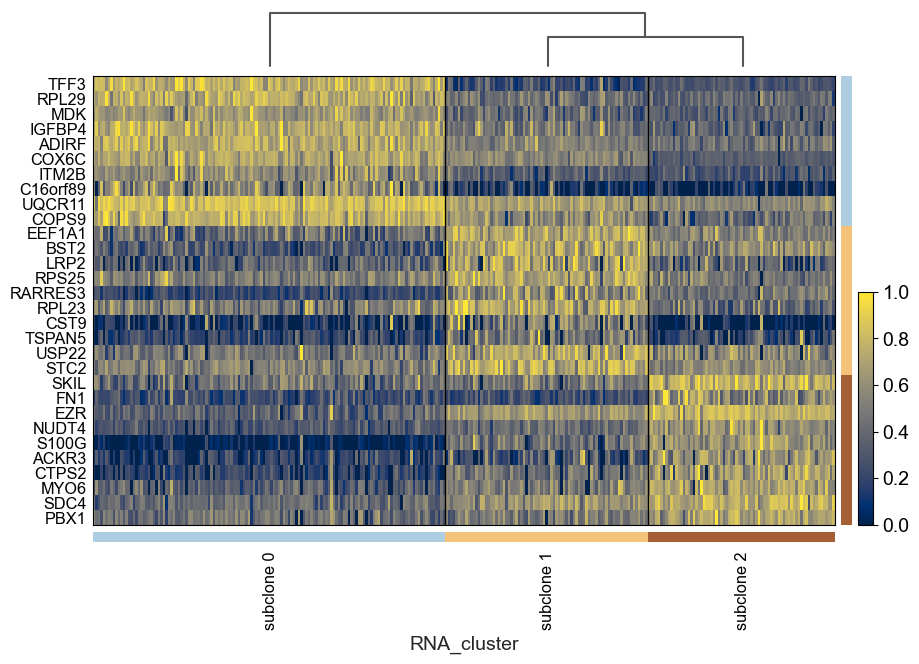

In [27]:
sc.pl.rank_genes_groups_heatmap(
    adata,n_genes=10,use_raw=True,standard_scale = 'var',swap_axes=True,cmap="cividis",figsize=(10, 7),save = 'dcis1clone.hm.pdf'
)

# SNV cluster

In [38]:
sample = 'dcis1'
snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
snv.obs['cluster'] = rna.obs['cluster']

In [39]:
snv.X = snv.layers['norm']

In [40]:
sc.pp.highly_variable_genes(snv, min_mean=0.0125, max_mean=3, min_disp=0.5)

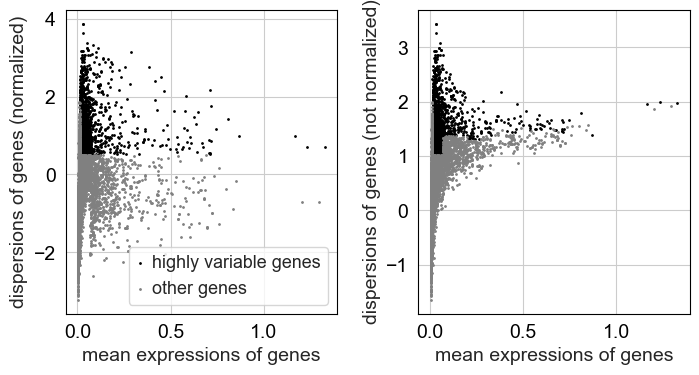

In [41]:
sc.pl.highly_variable_genes(snv)

In [42]:
snv.raw = snv.copy()

In [43]:
snv = snv[:, snv.var.highly_variable]

In [44]:
sc.pp.scale(snv, max_value=10)

/home/liuyi/miniconda3/envs/spatial/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


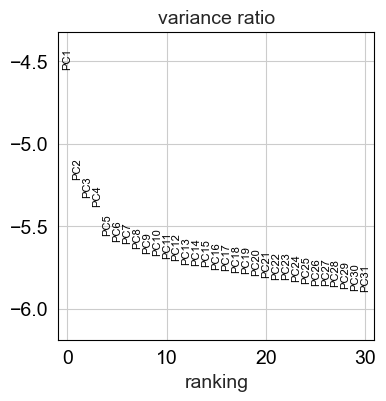

In [45]:
sc.tl.pca(snv, svd_solver="arpack")
sc.pl.pca_variance_ratio(snv, log=True)

In [46]:
sc.pp.neighbors(snv, n_neighbors=15, n_pcs=10)

In [47]:
sc.tl.leiden(snv,resolution=0.15,)

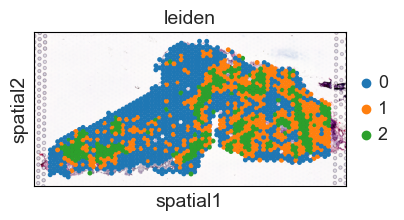

In [48]:
sc.pl.spatial(snv,color = 'leiden', spot_size = 70, basis = 'spatial')

In [51]:
snv.obs['cluster'] = rna.obs['cluster']

In [123]:
import importlib
import sys
sys.path.append('/storage/liuyi/00.SNP_project/jupyter/bin')
import spatialSNV_r as ss
importlib.reload(ss)

<module 'spatialSNV_r' from '/storage/liuyi/00.SNP_project/jupyter/bin/spatialSNV_r.py'>

In [137]:
sample = 'dcis1'
snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')
snv.obs['cluster'] = rna.obs['cluster']
snv = snv[snv.obs['cluster']=='Tumor']

In [138]:
snv_gene_adata = ss.bulid_windows(snv,window_size = 100000,basis = 'spatial')

In [139]:
sc.pp.normalize_total(snv_gene_adata, target_sum=1e4)
sc.pp.log1p(snv_gene_adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


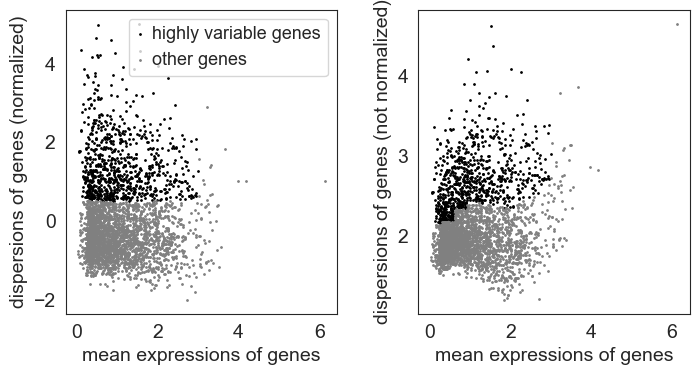

In [140]:
sc.pp.highly_variable_genes(snv_gene_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(snv_gene_adata)

In [141]:
sc.pp.scale(snv_gene_adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    with n_comps=50
    finished (0:00:00)


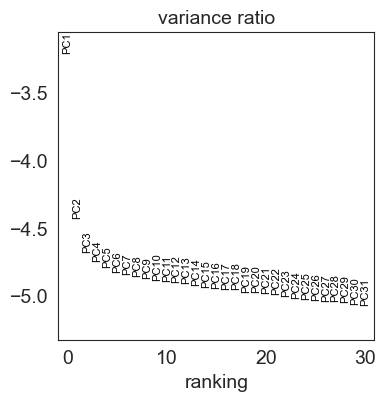

In [142]:
sc.tl.pca(snv_gene_adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(snv_gene_adata, log=True)

In [143]:
sc.pp.neighbors(snv, n_neighbors=15, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [146]:
sc.tl.leiden(snv,resolution=0.2,)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


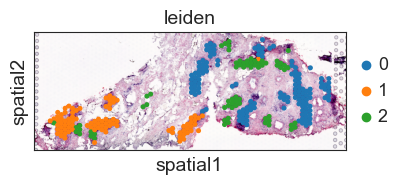

In [147]:
sc.pl.spatial(snv,color = 'leiden', spot_size = 70, basis = 'spatial')

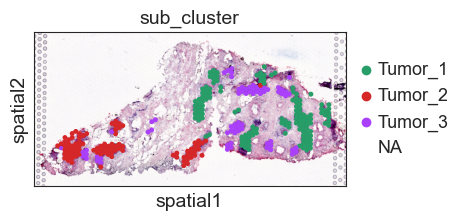

In [151]:
sc.pl.spatial(rna,groups = ['Tumor_1','Tumor_2','Tumor_3'],color = 'sub_cluster', spot_size = 70, basis = 'spatial')

In [166]:
snv.obs['sub_cluster'] = rna.obs['sub_cluster']
snv.obs['rename_leiden'] = snv.obs['leiden'].map({'0':'Tumor_1','1':'Tumor_2','2':'Tumor_3'})

In [167]:
snvdf = snv.obs[['rename_leiden','sub_cluster']].copy()

In [168]:
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(snvdf['sub_cluster'], snvdf['rename_leiden'])
print(f"Adjusted Rand Index: {ari_score}")

Adjusted Rand Index: 0.9919509966514609


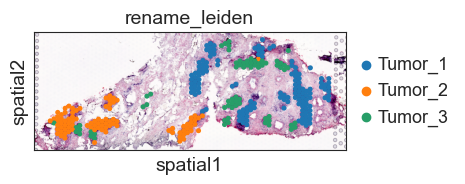

In [169]:
sc.pl.spatial(snv,color = 'rename_leiden', spot_size = 70, basis = 'spatial')

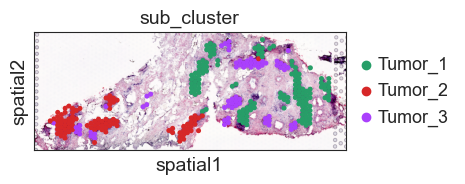

In [175]:
subrna = rna[rna.obs['sub_cluster'].isin(['Tumor_1','Tumor_2','Tumor_3'])]
sc.pl.spatial(subrna,color = 'sub_cluster', spot_size = 70, basis = 'spatial',save = 'rna.subcluster.pdf')

In [173]:
snv.uns['rename_leiden_colors'] = subrna.uns['sub_cluster_colors']

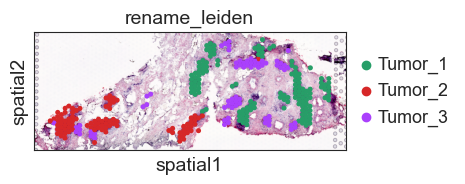

In [176]:
sc.pl.spatial(snv,color = 'rename_leiden', spot_size = 70, basis = 'spatial',save = 'snv.subcluster.pdf')